Welcome back (finally)! In the last week of the [Data Analysis Tools](https://www.coursera.org/learn/data-analysis-tools/) course, we're calculating (Pearson's) correlation coefficient $r$ for two quantitative variables *moderated by a third variable*.

Here's a short recap of my **Breast Cancer Causes Internet Usage!** (BCCIU) [project](http://lilithelina.tumblr.com/post/128347327089/choice-of-data): I chose to see if there is a relationship between breast cancer and internet usage or female employment, respectively, based on the reduced [Gapminder](http://www.gapminder.org/) data set provided in the [coursera](https://www.coursera.org/) course. The problem with this data is that the variables were all obtained in different years: breast cancer cases per 100,000 females were counted in 2002, while the female employment rate (as % of the female population aged 15 and above) was calculated for 2007, and internet users per 100 people were counted in 2010. This is why I'm not saying that internet usage causes breast cancer -- rather, I'm evaluating if the new breast cancer cases from 2002 influenced internet users and female employment in later years.  
So far, in the [Data Analysis and Interpretation](https://www.coursera.org/specializations/data-analysis) course series, we learned how to [prepare](http://lilithelina.tumblr.com/post/129435011659/data-preparation-python), [manage](http://lilithelina.tumblr.com/post/130065040767/data-management-python), and [visualise](http://lilithelina.tumblr.com/post/130899449414/data-visualisation-python) data in [python](https://www.python.org/), before moving on to data analysis. This included [ANOVA](http://lilithelina.tumblr.com/post/132593030304/data-analysis-anova-python) (comparing the means of different groups of the explanatory variable), the [Chi-squared](http://lilithelina.tumblr.com/post/133785457799/data-analysis-chi-square-python) test (comparing categorical variables), and [Pearson correlation](http://lilithelina.tumblr.com/post/135265946959/data-analysis-pearson-correlation-python) for numerical data.

In this last course week, we're adding a [moderator](https://en.wikipedia.org/wiki/Moderation_(statistics) -- a third variable that influences the relationship of our variables of interest. Since we are free to choose to which of the three methods (listed above) we applied so far we want to add this moderator, I'm going to calculate the Pearson correlation coefficient again. I have only numerical data, and using a test for numerical data makes the most sense.

As before, the output will look lots better in the [nbviewer](http://nbviewer.ipython.org/github/LilithElina/Data-Analysis-and-Interpretation/tree/master/DataAnaT/Week%20Four%20-%20Causation.ipynb) than on tumblr.

First up comes the code to prepare the raw data. This time, I'm not only filtering for the country identifiers and breast cancer, female employment, and internet usage, but also for income per person, which is the Gross Domestic Product per capita from 2010 (same year as the internet usage), and which will be the potential moderator.

In [1]:
# activate inline plotting, should be first statement
%matplotlib inline

# load packages
import warnings                     # ignore warnings (e.g. from future, deprecation, etc.)
warnings.filterwarnings('ignore')   # for layout reasons, after I read and acknowledged them all!

import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt
import scipy.stats                  # for pearson correlation

# read in data
data = pandas.read_csv("../gapminder.csv", low_memory=False)

# subset the data and make a copy to avoid error messages later on
sub = data[["country", "breastcancerper100th", "femaleemployrate", "internetuserate", "incomeperperson"]]
sub_data = sub.copy()

# change data types to numeric (NEW CODE!)
sub_data["breastcancerper100th"] = pandas.to_numeric(sub_data["breastcancerper100th"], errors="coerce")
sub_data["femaleemployrate"] = pandas.to_numeric(sub_data["femaleemployrate"], errors="coerce")
sub_data["internetuserate"] = pandas.to_numeric(sub_data["internetuserate"], errors="coerce")
sub_data["incomeperperson"] = pandas.to_numeric(sub_data["incomeperperson"], errors="coerce")

# replace empty values for income
sub_data["incomeperperson"] = sub_data["incomeperperson"].replace(" ", numpy.nan)

# remove rows with missing values (copy again)
sub2 = sub_data.dropna()
sub_data2 = sub2.copy()

The package `seaborn` includes the wonderful `pairplot()` function creating a nice visualisation of data sets. This is how my data looks now:

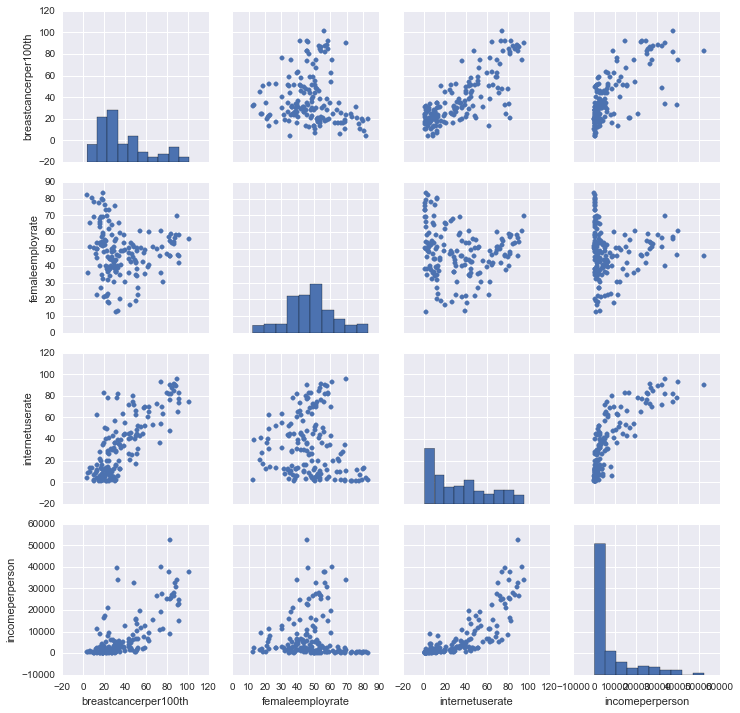

In [2]:
seaborn.pairplot(sub_data2);

The boxplots on the diagonal show the distribution of the four variables I'm looking at now. Only one, the female employment rate, looks normally distributed, while the other three are right skewed (income per person extremely so). While the plots are quite small, I believe that breast cancer still shows the only bimodal distribution (as I've shown [before](http://lilithelina.tumblr.com/post/130899449414/data-visualisation-python)), while all other variables are unimodal.

The "best" linear relationship can be seen in the scatterplots for breast cancer and internet usage, which prompted me to use these two variables as my main project. Female employment was only added because I needed one more variable for the course, just like I added income per person as potential moderator now. This creates intriguing scatterplots with the other three variables: in countries with low income per person, internet use rates are mostly also low, which seems reasonable. Breast cancer is apparently also more often detected in countries with higher income, but the relationship is not as clear as that with internet usage. The female employment rate, on the other hand, is particularly high in low income countries, but some countries with low income per person also show a low female employment rate. A female employment rate around 50% seems to be most common in countries with high income.
It will be interesting to see how it influences the relationships between them.

Scatterplots for the two relationships in question follow below, this time with fitted regression lines, courtesy of `seaborn`'s `regplot()` function.

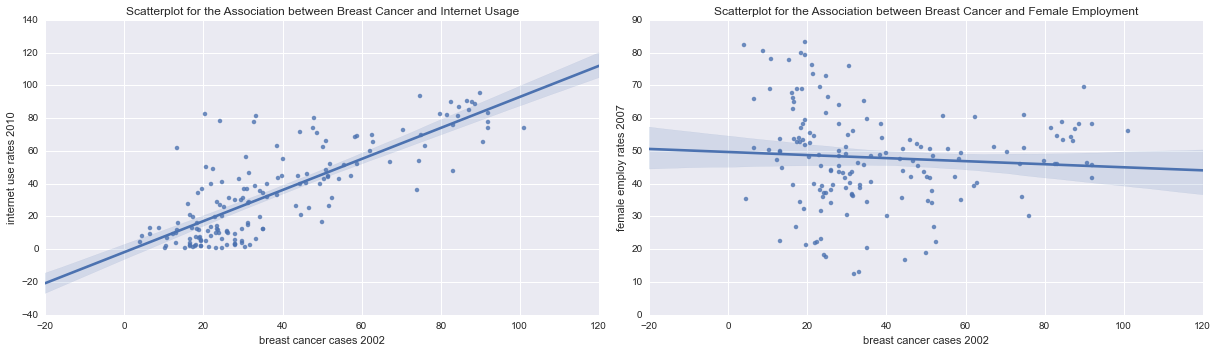

In [3]:
# plot bivariate scatterplots
fig = plt.figure(figsize=(17,5))

fig.add_subplot(121)
seaborn.regplot(x="breastcancerper100th", y="internetuserate", fit_reg=True, data=sub_data2);
plt.xlabel("breast cancer cases 2002");
plt.ylabel("internet use rates 2010");
plt.title("Scatterplot for the Association between Breast Cancer and Internet Usage");

fig.add_subplot(122)
seaborn.regplot(x="breastcancerper100th", y="femaleemployrate", fit_reg=True, data=sub_data2);
plt.xlabel("breast cancer cases 2002");
plt.ylabel("female employ rates 2007");
plt.title("Scatterplot for the Association between Breast Cancer and Female Employment");

fig.tight_layout()
plt.show()

We can again see a nice linear relationship between breast cancer and internet usage: in countries with more breast cancer cases (in 2002), more people used the internet in 2010. The relationship between breast cancer and female employment is not linear: while there is a high female employment rate in countries with only few breast cancer cases, and then a drop in employment when the breast cancer prevalence increases, countries with many breast cancer cases again show a higher female employment rate.

The moderator that is potentially influencing the relationships shown above (income per person) has to be a categorical variable, so I'll split it into quartiles.

In [4]:
# quartile split (use qcut function & ask for 4 groups) for breast cancer
print("income per person - quartiles")
sub_data2["incomequart"] = pandas.qcut(sub_data2.incomeperperson, 4,
                                           labels=["25th", "50th", "75th", "100th"])
sub_data2["incomequart"] = sub_data2.incomequart.astype("category")
print(sub_data2["incomequart"].value_counts(sort=False))

income per person - quartiles
25th     40
50th     40
75th     40
100th    40
dtype: int64


The trick we were taught in the course is now to split the data into subsets based on these moderator groups, and then simply checking for correlation in these subsets with `pearsonr()`, which returns $r$ and $p$ values.

In [5]:
# split into groups
by_income = sub_data2.groupby("incomequart")

# Pearson correlation between internet usage and breast cancer
print("association between internet usage and breast cancer cases - 25th income quartile")
print(scipy.stats.pearsonr(by_income.get_group("25th")["internetuserate"],
                           by_income.get_group("25th")["breastcancerper100th"]))

print("\nassociation between internet usage and breast cancer cases - 50th income quartile")
print(scipy.stats.pearsonr(by_income.get_group("50th")["internetuserate"],
                           by_income.get_group("50th")["breastcancerper100th"]))

print("\nassociation between internet usage and breast cancer cases - 75th income quartile")
print(scipy.stats.pearsonr(by_income.get_group("75th")["internetuserate"],
                           by_income.get_group("75th")["breastcancerper100th"]))

print("\nassociation between internet usage and breast cancer cases - 100th income quartile")
print(scipy.stats.pearsonr(by_income.get_group("100th")["internetuserate"],
                           by_income.get_group("100th")["breastcancerper100th"]))

print("\nassociation between internet usage and breast cancer cases - all")
print(scipy.stats.pearsonr(sub_data2["internetuserate"], sub_data2["breastcancerper100th"]))

association between internet usage and breast cancer cases - 25th income quartile
(0.43433520900435235, 0.0051046914276801809)

association between internet usage and breast cancer cases - 50th income quartile
(0.57050953813649752, 0.00012122114484346101)

association between internet usage and breast cancer cases - 75th income quartile
(0.63671255458970333, 1.0017264880229007e-05)

association between internet usage and breast cancer cases - 100th income quartile
(0.44301129713015486, 0.0041990999939948105)

association between internet usage and breast cancer cases - all
(0.79045386348908031, 1.851882207037223e-35)


As we can see, there is an increase in $r$ values for the first three income quartiles, showing that the linear relationship between breast cancer cases and internet usage grows stronger with higher per person income rates, before it is reduced again in countries with the highest income. None of the $r$ values can reach the "original" value though, showing a stronger relationship when no moderator is used.

This should also be possible to visualise in scatterplots with regression lines.

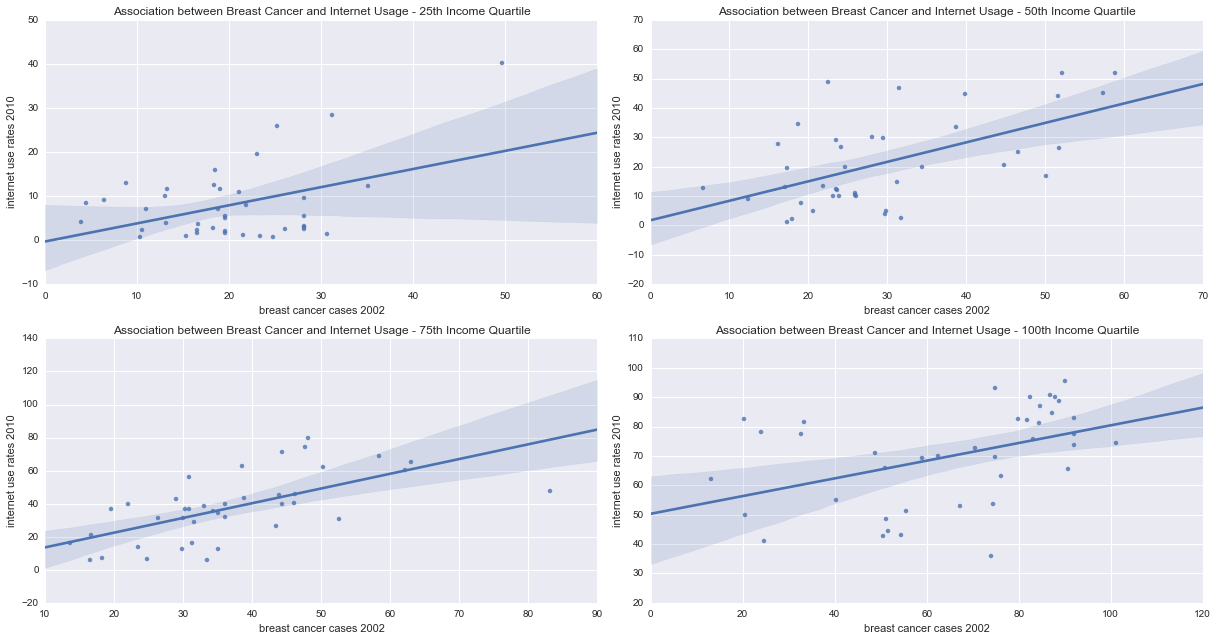

In [6]:
# plot bivariate scatterplots for internet usages versus breast cancer, with income as moderator
fig = plt.figure(figsize=(17,9))

fig.add_subplot(221)
seaborn.regplot(x="breastcancerper100th", y="internetuserate", fit_reg=True, data=by_income.get_group("25th"));
plt.xlabel("breast cancer cases 2002");
plt.ylabel("internet use rates 2010");
plt.title("Association between Breast Cancer and Internet Usage - 25th Income Quartile");

fig.add_subplot(222)
seaborn.regplot(x="breastcancerper100th", y="internetuserate", fit_reg=True, data=by_income.get_group("50th"));
plt.xlabel("breast cancer cases 2002");
plt.ylabel("internet use rates 2010");
plt.title("Association between Breast Cancer and Internet Usage - 50th Income Quartile");

fig.add_subplot(223)
seaborn.regplot(x="breastcancerper100th", y="internetuserate", fit_reg=True, data=by_income.get_group("75th"));
plt.xlabel("breast cancer cases 2002");
plt.ylabel("internet use rates 2010");
plt.title("Association between Breast Cancer and Internet Usage - 75th Income Quartile");

fig.add_subplot(224)
seaborn.regplot(x="breastcancerper100th", y="internetuserate", fit_reg=True, data=by_income.get_group("100th"));
plt.xlabel("breast cancer cases 2002");
plt.ylabel("internet use rates 2010");
plt.title("Association between Breast Cancer and Internet Usage - 100th Income Quartile");

fig.tight_layout()
plt.show()

In the low income group (25th quartile), we can see only one country with high breast cancer prevalence (almost 50 new cases per 100,000 females), and which also shows the highest internet use rate. This throws off the whole regression line and leads to a lower correlation coefficient $r$. Better correlation can be seen for the 50th and 75th income quartiles, before again a wider spread of values lowers the correlation for the highest income group.

Conclusions:  
1. Income per person has an effect on the strength of the relationship between breast cancer and internet usage.
2. The moderator does not change the overall, statistically significant positive correlation, or the linear relationship.
3. Income per person is not a well-chosen moderator here, since a stronger relationship between breast cancer cases and internet usage can be observed without including this variable.

The same approach can now also be used to test the influence of income on the relationship between female employment and breast cancer.

In [7]:
# Pearson correlation between internet usage and breast cancer
print("association between internet usage and breast cancer cases - 25th income quartile")
print(scipy.stats.pearsonr(by_income.get_group("25th")["femaleemployrate"],
                           by_income.get_group("25th")["breastcancerper100th"]))

print("\nassociation between internet usage and breast cancer cases - 50th income quartile")
print(scipy.stats.pearsonr(by_income.get_group("50th")["femaleemployrate"],
                           by_income.get_group("50th")["breastcancerper100th"]))

print("\nassociation between internet usage and breast cancer cases - 75th income quartile")
print(scipy.stats.pearsonr(by_income.get_group("75th")["femaleemployrate"],
                           by_income.get_group("75th")["breastcancerper100th"]))

print("\nassociation between internet usage and breast cancer cases - 100th income quartile")
print(scipy.stats.pearsonr(by_income.get_group("100th")["femaleemployrate"],
                           by_income.get_group("100th")["breastcancerper100th"]))

print("\nassociation between internet usage and breast cancer cases - all")
print(scipy.stats.pearsonr(sub_data2["femaleemployrate"], sub_data2["breastcancerper100th"]))

association between internet usage and breast cancer cases - 25th income quartile
(-0.35036696598846484, 0.026661899904757844)

association between internet usage and breast cancer cases - 50th income quartile
(-0.29934600559248525, 0.060589250678103501)

association between internet usage and breast cancer cases - 75th income quartile
(0.11231410740593266, 0.49019412821320973)

association between internet usage and breast cancer cases - 100th income quartile
(0.52362869886386654, 0.00052556564216060103)

association between internet usage and breast cancer cases - all
(-0.073712038131430999, 0.35426825185211674)


Ignoring income per person leads to a weak negative correlation coefficient with no statistical significance ($r=-0.07$, $p=0.35$), while all of the income-grouped comparisons between breast cancer and female employment lead to stronger correlation, which was in most cases (except for the 75th income quartile) also statistically significant. Really interesting here is the 100th quartile comprising the 40 countries with highest income per person -- for this group, the correlation between female employment and breast cancer is moderately strong and, most of all, positive instead of negative.

Let's have a look at the regressions for this.

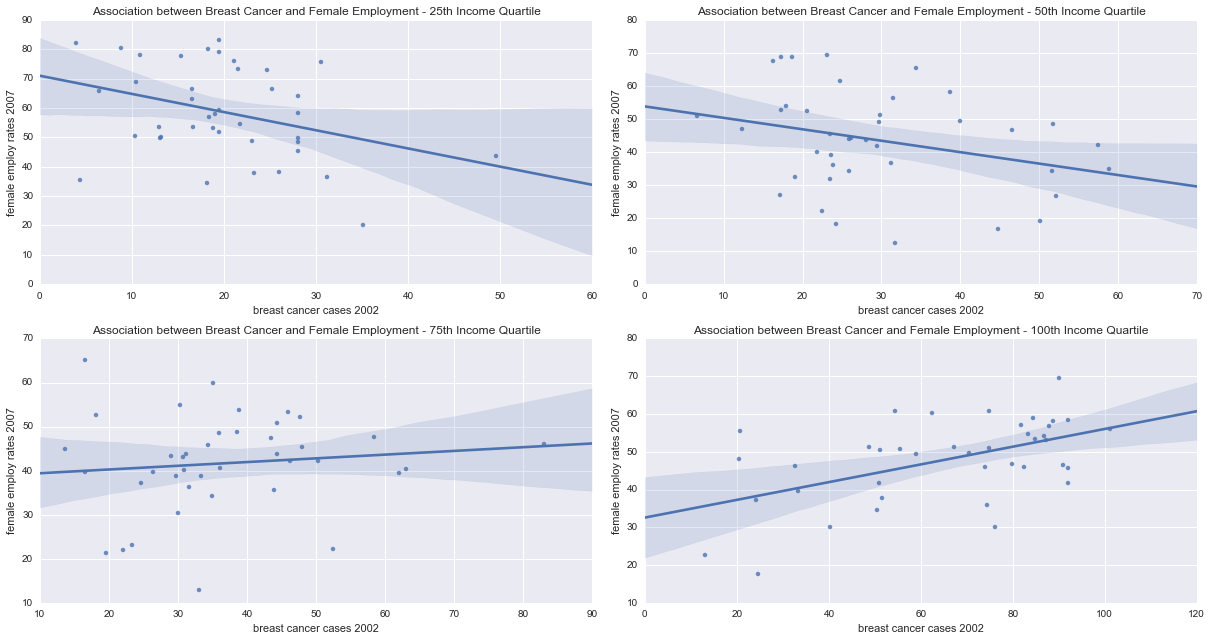

In [8]:
# plot bivariate scatterplots for internet usages versus breast cancer, with income as moderator
fig = plt.figure(figsize=(17,9))

fig.add_subplot(221)
seaborn.regplot(x="breastcancerper100th", y="femaleemployrate", fit_reg=True, data=by_income.get_group("25th"));
plt.xlabel("breast cancer cases 2002");
plt.ylabel("female employ rates 2007");
plt.title("Association between Breast Cancer and Female Employment - 25th Income Quartile");

fig.add_subplot(222)
seaborn.regplot(x="breastcancerper100th", y="femaleemployrate", fit_reg=True, data=by_income.get_group("50th"));
plt.xlabel("breast cancer cases 2002");
plt.ylabel("female employ rates 2007");
plt.title("Association between Breast Cancer and Female Employment - 50th Income Quartile");

fig.add_subplot(223)
seaborn.regplot(x="breastcancerper100th", y="femaleemployrate", fit_reg=True, data=by_income.get_group("75th"));
plt.xlabel("breast cancer cases 2002");
plt.ylabel("female employ rates 2007");
plt.title("Association between Breast Cancer and Female Employment - 75th Income Quartile");

fig.add_subplot(224)
seaborn.regplot(x="breastcancerper100th", y="femaleemployrate", fit_reg=True, data=by_income.get_group("100th"));
plt.xlabel("breast cancer cases 2002");
plt.ylabel("female employ rates 2007");
plt.title("Association between Breast Cancer and Female Employment - 100th Income Quartile");

fig.tight_layout()
plt.show()

In accordance with the correlation coefficients calculated above, the first two scatterplots show a regression line with negative slope, while the plots for higher income countries show a positive slope. This indicates that in low income countries, breast cancer leads to a reduction in female employment, while in high income countries (especially in the upper 40, the 100th quartile) more breast cancer cases correlate with higher female employment rates. This last statement is the strongest linear relationship we can get out of these data, but how can this be interpreted? In high income countries, more women worked in 2007 when more women had been diagnosed with breast cancer in 2002. On the other hand, less women worked in countries with low income and high breast cancer prevalence (though this is still much lower than that of high income countries).

Conclusions:
1. In low income countries, breast cancer is either not as prevalent or not as well detected as in high income countries.
2. An increase in breast cancer cases leads to a decrease of female employment in low income countries, indicating that ill women can't work.
3. An increase in breast cancer cases leads to an *increase* of female employment in high income countries, indicating that women diagnosed with cancer in 2002 are working in 2007. Maybe they have a better chance of survival, but also have to earn money to pay the medical bills?